# Add topic
Developed as part of European Union Horizon 2020 programme funded SCALE-UP project (grant agreement no. 955332).

## Import Data

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from utils import (
    compare_test_with_predicition,
    fit_model,
    get_parkings_df, 
    get_parkings_in_zone,
    get_hourly_parkings,
    get_pipeline,
    get_weather_data,
    add_seasonability_columns,
    predict,
    plot_predictions,
    print_results,
    BASE,
    MINUS_10,
    MINUS_20,
    ZERO,
    PLUS_10,
    PLUS_20,
    DRY_WEATHER,
    SEASONABILITY_COLUMNS,
    RAIN,
    TEMPERATURE,
    YEAR,
    ONEHOT_SCALER_COLUMNS
)


## Load and prepare data

In [2]:
df_parkings = get_parkings_df("../data/parkings_small.csv")
parkings_in_zone = get_parkings_in_zone(df_parkings, 1)
print(f"Found {len(parkings_in_zone)} parkings in zone")
hourly_parkings = get_hourly_parkings(parkings_in_zone)
# clean data by removing early data days without cars
hourly_parkings = hourly_parkings[hourly_parkings["ds"]> "2024-5-20"]
df_rain, df_temperature = get_weather_data()
hourly_parking = pd.merge(hourly_parkings, df_rain, on="ds", how='left')
hourly_parking = pd.merge(hourly_parking, df_temperature, on="ds", how='left')
hourly_parking.head()
df = hourly_parking.copy()
df.set_index("ds", inplace=True)

df_rain_train = pd.merge(hourly_parkings, df_rain, on="ds", how='left')
df_rain_train.set_index("ds", inplace=True)

df_temperature_train = pd.merge(hourly_parkings, df_temperature, on="ds", how='left')
df_temperature_train.set_index("ds", inplace=True)

Found 718955 parkings in zone


## Create pipelines and train models

#

mean squared error: 5598.766015697399
mean squared error: 5602.823520188579
mean squared error: 5859.256605465568


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'month',
                                                   'dayofweek']),
                                                 ('Standard', StandardScaler(),
                                                  ['temperature', 'year'])])),
                ('regressor', LinearRegression())])

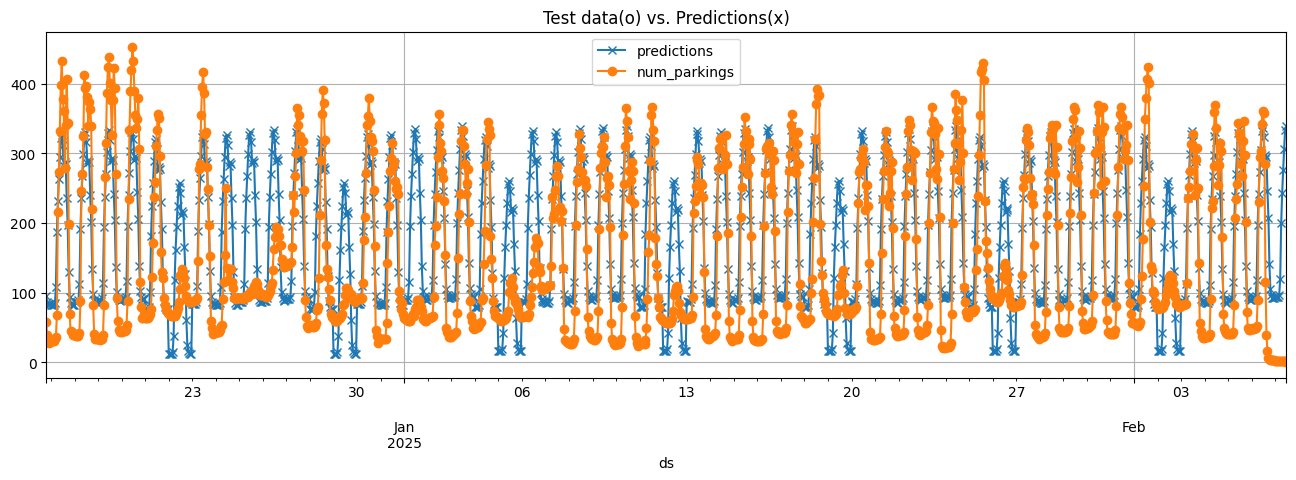

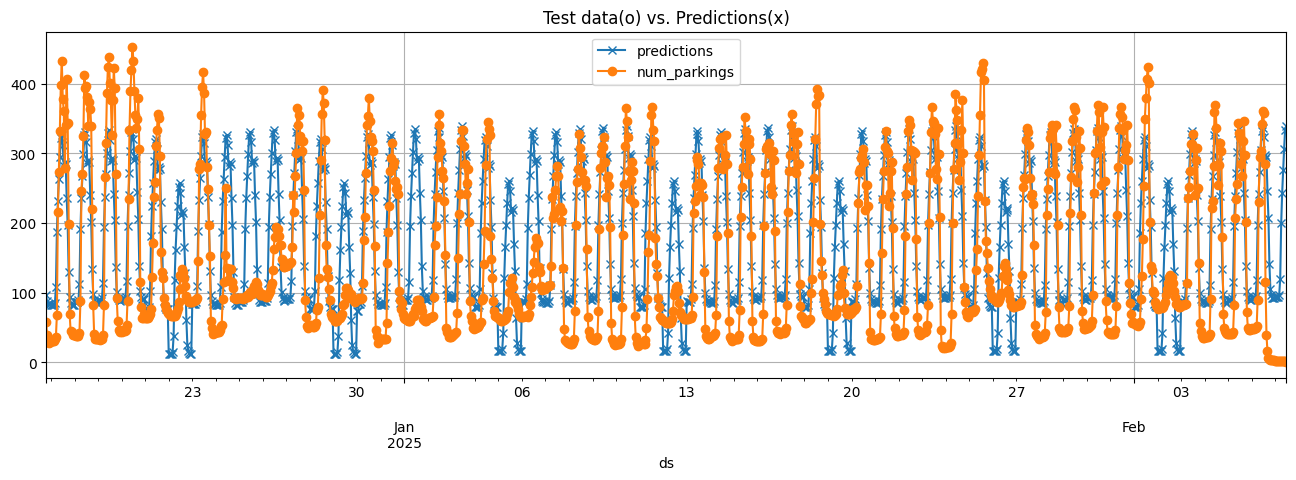

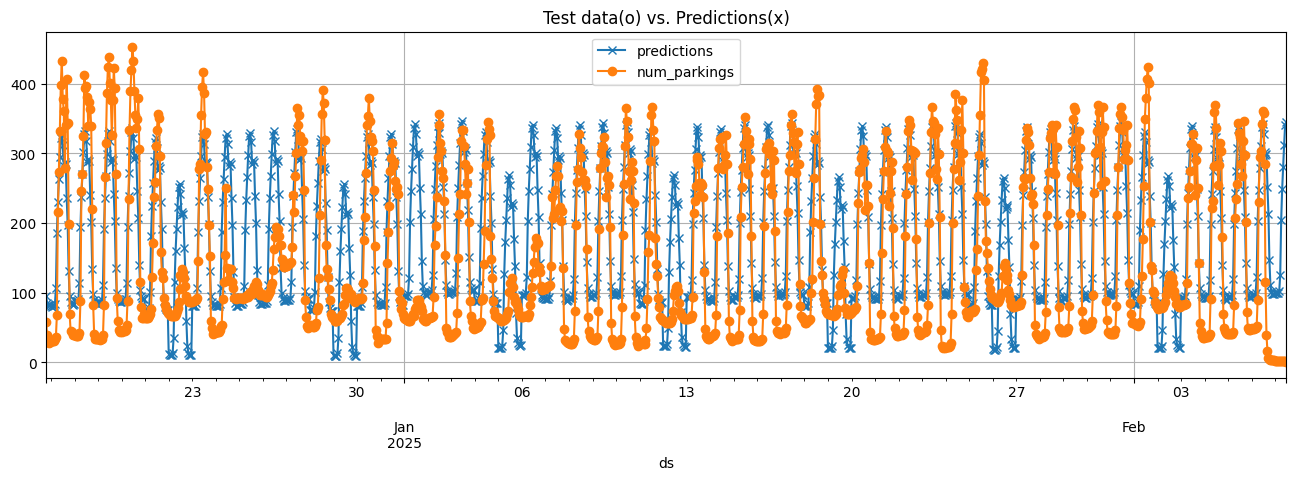

In [3]:
df_base = add_seasonability_columns(df)
pipeline = get_pipeline(LinearRegression(), standard_columns=[YEAR])
X_test, y_test = fit_model(pipeline, df_base, SEASONABILITY_COLUMNS)
compare_test_with_predicition(pipeline, X_test, y_test)
df_rain_train = add_seasonability_columns(df_rain_train)
pipeline_rain = get_pipeline(LinearRegression(), standard_columns=[YEAR, RAIN])
X_test, y_test = fit_model(pipeline_rain, df_rain_train, SEASONABILITY_COLUMNS+[RAIN])
compare_test_with_predicition(pipeline_rain, X_test, y_test)
df_temperature_train = add_seasonability_columns(df_temperature_train)
pipeline_temperature = get_pipeline(LinearRegression(), standard_columns=[TEMPERATURE, YEAR])
X_test, y_test = fit_model(pipeline_temperature, df_temperature_train, SEASONABILITY_COLUMNS+[TEMPERATURE])
compare_test_with_predicition(pipeline_temperature, X_test, y_test)

## Make predictions

In [4]:
results = {}
date_range = pd.date_range(start="2025-02-07 11:00:00", end="2025-03-09 11:00:00", freq="h")
results[BASE] = predict(pipeline, date_range)
results[RAIN] = predict(pipeline_rain, date_range, rain=True)
results[DRY_WEATHER] = predict(pipeline_rain, date_range, rain=False)
results[MINUS_20] = predict(pipeline_temperature, date_range, temperature=-20)
results[MINUS_10] = predict(pipeline_temperature, date_range, temperature=-10)
results[ZERO] = predict(pipeline_temperature, date_range, temperature=0)
results[PLUS_10] = predict(pipeline_temperature, date_range, temperature=10)
results[PLUS_20] = predict(pipeline_temperature, date_range, temperature=20)
print_results(date_range, results)

Forecast period: 2025-02-07 11:00:00 - 2025-03-09 11:00:00
Base forecast for parkings: 125807.
Forecast for parkings in rain: 118484.  Diff to base -7323
Forecast for parkings in dry weather: 125860.  Diff to base 53
Forecast for parkings in -20 degrees temperature: 135569.  Diff to base 9762
Forecast for parkings in -10 degrees temperature: 132561.  Diff to base 6754
Forecast for parkings in 0 degrees temperature: 129552.  Diff to base 3745
Forecast for parkings in 10 degrees temperature: 126544.  Diff to base 737
Forecast for parkings in 20 degrees temperature: 123535.  Diff to base -2272
